In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

from random import seed
from random import random
import random
import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
sys.path.append("C:\\Users\\kirti\\Documents\\NASA_Codes\\Python_codes\\")
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [2]:
from tslearn.metrics import dtw as dtw_metric
# https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


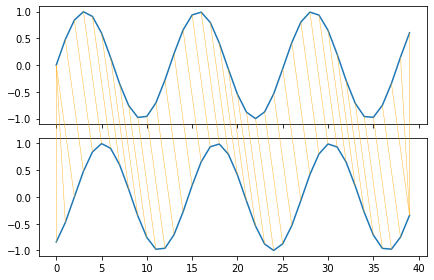

In [3]:
x = np.arange(0, 20, .5)
s1 = np.sin(x)
s2 = np.sin(x - 1)
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
distance = dtw.distance(s1, s2)

# Read Fields Metadata

In [29]:
meta_dir = "/Users/hn/Documents/01_research_data/NASA/parameters/"
meta_dir = "C:\\Users\\kirti\\Documents\\NASA_data\\parameters\\"
meta = pd.read_csv(meta_dir+"evaluation_set.csv")
meta.head(2)

,ID,CropTyp,Irrigtn,DataSrc,Acres,ExctAcr,LstSrvD,county
0,100010_WSDA_SF_2017,alfalfa hay,center pivot,wsda,34,34.310305,2017/09/12,Grant
1,100204_WSDA_SF_2017,alfalfa hay,center pivot,wsda,62,61.826535,2017/08/09,Grant


In [31]:
meta_moreThan10Acr=meta[meta.ExctAcr>10]
print (meta.shape)
print (meta_moreThan10Acr.shape)

(6340, 8)
(3539, 8)


# Read Training Set Labels

In [32]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
training_set_dir = "C:\\Users\\kirti\\Documents\\NASA_data\\ML_data\\"
ground_truth_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", ground_truth_labels.Vote.unique())
print (len(ground_truth_labels.ID.unique()))
ground_truth_labels.head(2)

Unique Votes:  [2 1]
1849


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Read the Data

In [33]:
VI_idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/04_regularized_TS/"
data_dir = "C:\\Users\\kirti\\Documents\\NASA_data\\VI_TS\\04_regularized_TS\\"

In [34]:
file_names = ["regular_Walla2015_EVI_JFD.csv", "regular_AdamBenton2016_EVI_JFD.csv", 
              "regular_Grant2017_EVI_JFD.csv", "regular_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.049624
1,135073_WSDA_SF_2015,2015-01-20,0.026503


In [35]:
ground_truth = data[data.ID.isin(list(ground_truth_labels.ID.unique()))].copy()

# Toss small fields

In [36]:
ground_truth = ground_truth[ground_truth.ID.isin((list(meta_moreThan10Acr.ID)))].copy()
ground_truth_labels = ground_truth_labels[ground_truth_labels.ID.isin((list(meta_moreThan10Acr.ID)))].copy()

# Sort the order of time-series and experts' labels identically

In [37]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

assert (len(ground_truth.ID.unique()) == len(ground_truth_labels.ID.unique()))

print (list(ground_truth.ID)[0])
print (list(ground_truth_labels.ID)[0])
print ("____________________________________")
print (list(ground_truth.ID)[-1])
print (list(ground_truth_labels.ID)[-1])
print ("____________________________________")
print (list(ground_truth.ID.unique())==list(ground_truth_labels.ID.unique()))

100048_WSDA_SF_2017
100048_WSDA_SF_2017
____________________________________
99909_WSDA_SF_2017
99909_WSDA_SF_2017
____________________________________
True


In [38]:
ground_truth.head(2)

,ID,human_system_start_time,EVI
0,100048_WSDA_SF_2017,2017-01-06,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0


In [39]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


In [40]:
mins = ground_truth.groupby("ID")[VI_idx].min()
maxs = ground_truth.groupby("ID")[VI_idx].max()
_ranges = maxs-mins
_ranges = pd.DataFrame(_ranges)
_ranges.reset_index(inplace=True)

mins = pd.DataFrame(mins)
mins.reset_index(inplace=True)


_ranges.rename(columns = {'EVI':'EVI_range'}, inplace = True)
mins.rename(columns = {'EVI':'EVI_min'}, inplace = True)

print (_ranges.head(2))

ground_truth = pd.merge(ground_truth, _ranges, on=['ID'], how='left')
ground_truth = pd.merge(ground_truth, mins, on=['ID'], how='left')
ground_truth["EVI_ratio"] = (ground_truth["EVI"]-ground_truth["EVI_min"])/ground_truth["EVI_range"]
ground_truth.head(2)

                    ID  EVI_range
0  100048_WSDA_SF_2017   0.602470
1  100081_WSDA_SF_2017   0.721754


,ID,human_system_start_time,EVI,EVI_range,EVI_min,EVI_ratio
0,100048_WSDA_SF_2017,2017-01-06,0.0,0.60247,0.0,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0,0.60247,0.0,0.0


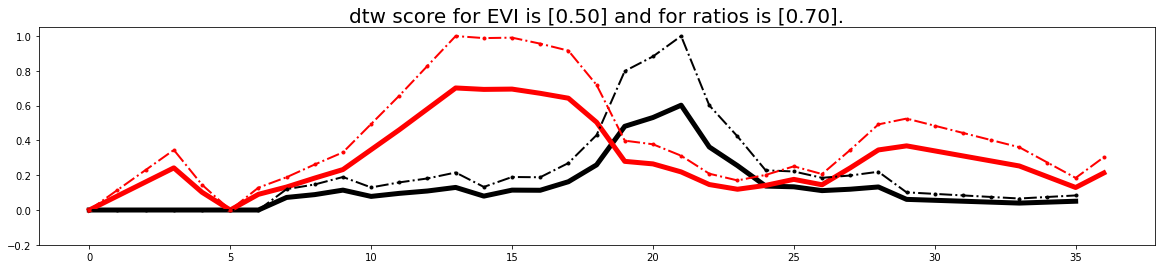

In [42]:
ID_1=ground_truth.ID.unique()[0]
ID_2=ground_truth.ID.unique()[12]

# _minimum = ground_truth[ground_truth.ID==ID_1].EVI.values.min()
# _range = ground_truth[ground_truth.ID==ID_1].EVI.values.max()-_minimum
# y_1 = (ground_truth[ground_truth.ID==ID_1].EVI.values-_minimum)/_range
# _minimum = ground_truth[ground_truth.ID==ID_2].EVI.values.min()
# _range = ground_truth[ground_truth.ID==ID_2].EVI.values.max()-_minimum
# y_2 = (ground_truth[ground_truth.ID==ID_2].EVI.values-_minimum)/_range

dtw_score = dtw_metric(ground_truth[ground_truth.ID==ID_1].EVI.values, 
                ground_truth[ground_truth.ID==ID_2].EVI.values)

dtw_score_ratios = dtw_metric(ground_truth[ground_truth.ID==ID_1].EVI_ratio.values, 
                       ground_truth[ground_truth.ID==ID_2].EVI_ratio.values)

# print ("dtw score is {:.2f}.".format(dtw_score))

plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

# plot EVIs
plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
         ground_truth[ground_truth.ID==ID_1].EVI.values,
        c='k', linewidth=5);


plt.plot(range(len(ground_truth[ground_truth.ID==ID_2].human_system_start_time.values)),
         ground_truth[ground_truth.ID==ID_2].EVI.values,
        c='red', linewidth=5);

# plot ratios
plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)), 
         ground_truth[ground_truth.ID==ID_1].EVI_ratio.values,
         ".-.", c='k', linewidth=2, label="ratios");

plt.plot(range(len(ground_truth[ground_truth.ID==ID_2].human_system_start_time.values)), 
         ground_truth[ground_truth.ID==ID_2].EVI_ratio.values,
         ".-.", c='red', linewidth=2, label="ratios");


title = "dtw score for EVI is [{:.2f}] and for ratios is [{:.2f}].".format(dtw_score, dtw_score_ratios)
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize = 20);

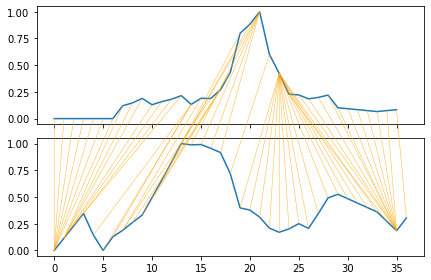

In [43]:
s1=ground_truth[ground_truth.ID==ID_1].EVI_ratio.values
s2=ground_truth[ground_truth.ID==ID_2].EVI_ratio.values
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
distance = dtw.distance(s1, s2)

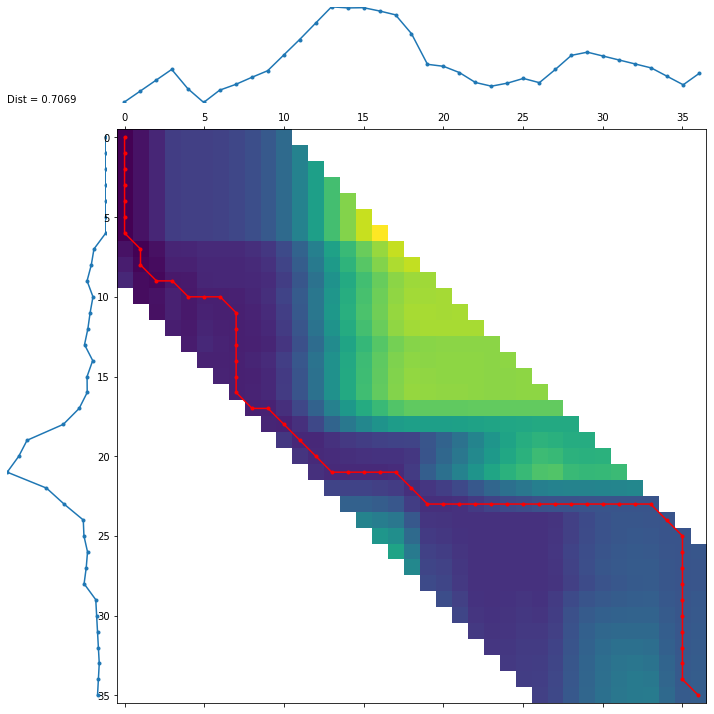

In [44]:
d, paths = dtw.warping_paths(s1, s2, window=10, use_pruning=True);
best_path = dtw.best_path(paths);
dtwvis.plot_warpingpaths(s1, s2, paths, best_path);

# Human Activity

In [45]:
# HA_dir = "/Users/hn/Downloads/UCI_HAR_Dataset/"

# x_train_file = open(HA_dir + '/train/X_train.txt', 'r')
# y_train_file = open(HA_dir + '/train/y_train.txt', 'r')
# x_test_file = open(HA_dir + '/test/X_test.txt', 'r')
# y_test_file = open(HA_dir + '/test/y_test.txt', 'r')
# # Create empty lists
# x_train = []
# y_train = []
# x_test = []
# y_test = []
# # Mapping table for classes
# labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
#           4:'SITTING', 5:'STANDING', 6:'LAYING'}
# # Loop through datasets
# for x in x_train_file:
#     x_train.append([float(ts) for ts in x.split()])
    
# for y in y_train_file:
#     y_train.append(int(y.rstrip('\n')))
    
# for x in x_test_file:
#     x_test.append([float(ts) for ts in x.split()])
    
# for y in y_test_file:
#     y_test.append(int(y.rstrip('\n')))
    
# # Convert to numpy for efficiency
# x_train = np.array(x_train)
# y_train = np.array(y_train)
# x_test = np.array(x_test)
# y_test = np.array(y_test)
# colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
#           '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

# d,_ = dtw.warping_paths(s1, s2, window=10, use_pruning=True);
# print (d)

# d,_ = dtw.warping_paths(s1, s2);
# print (d)

# %%time
# idx=0
# for r in range(1000):
#     distance_prune = dtw.distance(x_train[idx], x_test[r], window=20, use_pruning='True')
    
# for r in range(1000): # len(x_test)
#     distance = dtw.distance(x_train[idx], x_test[r])


# def classifyNN(k:int, idx:int) -> str:
#     idxs=range(0,x_train.shape[0])
#     n=x_train.shape[0]
#     distances=[]
#     counters={}
#     c=1;
#     max_value=0

In [46]:
def DTW_prune(ts1, ts2):
    d,_ = dtw.warping_paths(ts1, ts2, window=10, use_pruning=True);
    return d
    

# Widen Ground Truth Table

In [47]:
EVI_colnames = [VI_idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
ground_truth_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(ground_truth.ID.unique())))
ground_truth_wide["ID"] = ground_truth.ID.unique()

for an_ID in ground_truth.ID.unique():
    curr_df = ground_truth[ground_truth.ID==an_ID]
    
    ground_truth_wide_indx = ground_truth_wide[ground_truth_wide.ID==an_ID].index
    ground_truth_wide.loc[ground_truth_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]

In [48]:
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100048_WSDA_SF_2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072227,0.088491,...,0.111507,0.119534,0.13248,0.061173,0.055843,0.050513,0.045183,0.039854,0.045165,0.050476
1,100081_WSDA_SF_2017,0.014832,0.167038,0.319244,0.47145,0.378153,0.284855,0.198468,0.290683,0.398445,...,0.096717,0.117915,0.159058,0.121182,0.060591,0.0,0.050004,0.100009,0.102269,0.104529


In [49]:
ground_truth_labels.shape

(1342, 2)

# Split Train and Test Set

#### Make sure rows of ```ground_truth_allBands``` and ```ground_truth_labels``` are in the same order

In [50]:
ground_truth_labels = ground_truth_labels.set_index('ID')
ground_truth_labels = ground_truth_labels.reindex(index=ground_truth_wide['ID'])
ground_truth_labels = ground_truth_labels.reset_index()

In [51]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


In [52]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_wide, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=ground_truth_labels.Vote.values)

# Train

In [53]:
%%time
parameters = {'n_neighbors':[2, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20],
              "weights":["uniform"]}
KNN_DTW_prune = GridSearchCV(KNeighborsClassifier(metric=DTW_prune), parameters, cv=5, verbose=1)
KNN_DTW_prune.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
CPU times: total: 5h 15min 11s
Wall time: 11h 6min 56s


GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric=<function DTW_prune at 0x0000026436C16AF0>),
             param_grid={'n_neighbors': [2, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                         17, 20],
                         'weights': ['uniform']},
             verbose=1)

In [54]:
print (KNN_DTW_prune.best_params_)

{'n_neighbors': 11, 'weights': 'uniform'}


In [55]:
x_test_df = x_test_df[x_test_df.ID.isin((list(meta_moreThan10Acr.ID)))].copy()
y_test_df = y_test_df[y_test_df.ID.isin((list(meta_moreThan10Acr.ID)))].copy()

In [56]:
%%time
KNN_DTW_prune_predictions = KNN_DTW_prune.predict(x_test_df.iloc[:, 1:])

CPU times: total: 7min 13s
Wall time: 7min 14s


In [57]:
(KNN_DTW_prune_predictions==y_test_df.Vote).sum()

259

# Definitions

  - **Precision** Of all instances we predict $\hat y = 1$, what fraction is actually 1.
     \begin{equation}\label{eq:precision}
        \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
     \end{equation}

  - **Recall** Of all instances that are actually $y = 1$, what fraction we predict 1.
     \begin{equation}\label{eq:recall}
         \text{Recall} = \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
     \end{equation}
     
  - **Specifity** Fraction of all negative instances that are incorrectly predicted positive.
     \begin{equation}\label{eq:specifity}
        \text{Specifity} = \text{FPR} = \frac{\text{FP}}{\text{TN} + \text{FP}}\\
     \end{equation}
     
  - **F-Score** Adjust $\beta$ for trade off between  precision and recall. For precision oriented task $\beta = 0.5$.
     \begin{equation}\label{eq:Fscore}
        F_\beta = \frac{(1+\beta^2) \times \text{TP}}{ (1+\beta^2) \times  \text{TP} + \beta^2 \text{FN} + \text{FP}}
     \end{equation}



In [58]:
y_test_df_copy=y_test_df.copy()
y_test_df_copy["KNN_DTW_prune_predictions"] = list(KNN_DTW_prune_predictions)
y_test_df_copy.head(2)

,ID,Vote,KNN_DTW_prune_predictions
1221,7667_WSDA_SF_2016,1,1
1334,99748_WSDA_SF_2017,1,1


In [59]:
true_single_predicted_single=0
true_single_predicted_double=0

true_double_predicted_single=0
true_double_predicted_double=0

for index in y_test_df_copy.index:
    curr_vote=list(y_test_df_copy[y_test_df_copy.index==index].Vote)[0]
    curr_predict=list(y_test_df_copy[y_test_df_copy.index==index].KNN_DTW_prune_predictions)[0]
    if curr_vote==curr_predict:
        if curr_vote==1:
            true_single_predicted_single+=1
        else:
            true_double_predicted_double+=1
    else:
        if curr_vote==1:
            true_single_predicted_double+=1
        else:
            true_double_predicted_single+=1

# Confusion Table for Test Set

In [60]:
confus_tbl_test = pd.DataFrame(columns=['NoName', 'Predict_Single', 'Predict_Double'], 
                               index=range(2))
confus_tbl_test.loc[0, 'NoName'] = 'Actual_Single'
confus_tbl_test.loc[1, 'NoName'] = 'Actual_Double'
confus_tbl_test['Predict_Single']=0
confus_tbl_test['Predict_Double']=0

confus_tbl_test.loc[0, "Predict_Single"]=true_single_predicted_single
confus_tbl_test.loc[0, "Predict_Double"]=true_single_predicted_double
confus_tbl_test.loc[1, "Predict_Single"]=true_double_predicted_single
confus_tbl_test.loc[1, "Predict_Double"]=true_double_predicted_double
confus_tbl_test

,NoName,Predict_Single,Predict_Double
0,Actual_Single,213,6
1,Actual_Double,4,46


In [61]:
print(classification_report(y_test_df.Vote, KNN_DTW_prune_predictions))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98       219
           2       0.88      0.92      0.90        50

    accuracy                           0.96       269
   macro avg       0.93      0.95      0.94       269
weighted avg       0.96      0.96      0.96       269



In [63]:
print ("IF **Single** is positive and double is negative:")
print ("")

TP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Single"]["Predict_Single"])[0]
FP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Double"]["Predict_Single"])[0]
FN = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Single"]["Predict_Double"])[0]
print ("Precision is [{0:.2f}]".format(TP/(TP+FP)))
print ("Recall is [{0:.2f}]".format(TP/(TP+FN)))

print ("_________________________________________________________")
print ("IF **Single** is negative. double is positive:")

TP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Double"]["Predict_Double"])[0]
FP = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Single"]["Predict_Double"])[0]
FN = list(confus_tbl_test[confus_tbl_test.NoName=="Actual_Double"]["Predict_Single"])[0]

print ("")
print ("Precision is [{0:.2f}]".format(TP/(TP+FP)))
print ("Recall is [{0:.2f}]".format(TP/(TP+FN)))

IF **Single** is positive and double is negative:

Precision is [0.98]
Recall is [0.97]
_________________________________________________________
IF **Single** is negative. double is positive:

Precision is [0.88]
Recall is [0.92]


# Export Trained Model

In [65]:
import pickle
model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"
model_dir = "C:\\Users\\kirti\\Documents\\NASA_data\\ML_Models\\"

filename = model_dir + "00_KNN_regular_EVI_DTW_prune_" + KNN_DTW_prune.best_params_["weights"] + "Weight_" + \
                        str(KNN_DTW_prune.best_params_["n_neighbors"]) + "NNisBest.sav"

pickle.dump(KNN_DTW_prune, open(filename, 'wb'))

In [66]:
# How to load the saved model:
# loaded_model_KNN_DTW_prune = pickle.load(open(filename, 'rb'))
# loaded_model.predict(x_test_df.iloc[0:2, 1:])

In [67]:
# %%time
# parameters = {'n_neighbors':[10]}
# KNN_DTW_prune_10NN = GridSearchCV(KNeighborsClassifier(metric=DTW_prune), parameters, cv=5, verbose=1);
# KNN_DTW_prune_10NN.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values);
# %%time
# KNN_DTW_prune_10NN_predictions = KNN_DTW_prune_10NN.predict(x_test_df.iloc[:, 1:])

# Improve?

### Lets see if putting weights will make a difference

In [68]:
%%time
parameters = {'n_neighbors':[2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
              "weights":["distance"]}
KNN_DTW_prune_weightsDistance = GridSearchCV(KNeighborsClassifier(metric=DTW_prune), 
                                             parameters, cv=5, verbose=1)
KNN_DTW_prune_weightsDistance.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
CPU times: total: 6h 37min 10s
Wall time: 6h 39min 35s


GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric=<function DTW_prune at 0x0000026436C16AF0>),
             param_grid={'n_neighbors': [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19, 20],
                         'weights': ['distance']},
             verbose=1)

In [69]:
print ("KNN_DTW_prune_weightsDistance.best_params_ is", KNN_DTW_prune_weightsDistance.best_params_)
print ("KNN_DTW_prune.best_params_ is", KNN_DTW_prune.best_params_)

KNN_DTW_prune_weightsDistance.best_params_ is {'n_neighbors': 12, 'weights': 'distance'}
KNN_DTW_prune.best_params_ is {'n_neighbors': 11, 'weights': 'uniform'}


In [70]:
%%time
KNN_DTW_prune_weightsDistance_predictions = KNN_DTW_prune_weightsDistance.predict(x_test_df.iloc[:, 1:])

CPU times: total: 7min 5s
Wall time: 7min 6s


In [71]:
print ("******* KNN_DTW_prune_predictions *******")
print(classification_report(y_test_df.Vote, KNN_DTW_prune_predictions))
print ("====================================================================================")
print ("******* KNN_DTW_prune_weightsDistance_predictions *******")
print(classification_report(y_test_df.Vote, KNN_DTW_prune_weightsDistance_predictions))

******* KNN_DTW_prune_predictions *******
              precision    recall  f1-score   support

           1       0.98      0.97      0.98       219
           2       0.88      0.92      0.90        50

    accuracy                           0.96       269
   macro avg       0.93      0.95      0.94       269
weighted avg       0.96      0.96      0.96       269

******* KNN_DTW_prune_weightsDistance_predictions *******
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       219
           2       0.87      0.94      0.90        50

    accuracy                           0.96       269
   macro avg       0.93      0.95      0.94       269
weighted avg       0.96      0.96      0.96       269



# Confusion Table for Test Set

In [72]:
y_test_df_copy=y_test_df.copy()
y_test_df_copy["weightDist_predictions"] = list(KNN_DTW_prune_weightsDistance_predictions)
y_test_df_copy.head(2)

true_single_predicted_single=0
true_single_predicted_double=0

true_double_predicted_single=0
true_double_predicted_double=0

actual_double_predicted_single_IDs=[]
actual_single_predicted_double_IDs=[]

for index in y_test_df_copy.index:
    curr_vote=list(y_test_df_copy[y_test_df_copy.index==index].Vote)[0]
    curr_predict=list(y_test_df_copy[y_test_df_copy.index==index].weightDist_predictions)[0]
    if curr_vote==curr_predict:
        if curr_vote==1:
            true_single_predicted_single+=1
        else:
            true_double_predicted_double+=1
    else:
        if curr_vote==1:
            true_single_predicted_double+=1
            actual_single_predicted_double_IDs+=list(y_test_df_copy[y_test_df_copy.index==index].ID)
        else:
            true_double_predicted_single+=1
            actual_double_predicted_single_IDs += list(y_test_df_copy[y_test_df_copy.index==index].ID)

confus_tbl_test = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], 
                               index=range(2))
confus_tbl_test.loc[0, 'None'] = 'Actual_Single'
confus_tbl_test.loc[1, 'None'] = 'Actual_Double'
confus_tbl_test['Predict_Single']=0
confus_tbl_test['Predict_Double']=0

confus_tbl_test.loc[0, "Predict_Single"]=true_single_predicted_single
confus_tbl_test.loc[0, "Predict_Double"]=true_single_predicted_double
confus_tbl_test.loc[1, "Predict_Single"]=true_double_predicted_single
confus_tbl_test.loc[1, "Predict_Double"]=true_double_predicted_double
confus_tbl_test

,None,Predict_Single,Predict_Double
0,Actual_Single,212,7
1,Actual_Double,3,47


In [73]:
import pickle
model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"
model_dir = "C:\\Users\\kirti\\Documents\\NASA_data\\ML_Models\\"
filename = model_dir + "00_KNN_regular_EVI_DTW_prune_" + KNN_DTW_prune_weightsDistance.best_params_["weights"] + \
                       "Weight_" + str(KNN_DTW_prune_weightsDistance.best_params_["n_neighbors"]) + \
                       "NNisBest.sav"

pickle.dump(KNN_DTW_prune_weightsDistance, open(filename, 'wb'))

In [74]:
actual_double_predicted_single_IDs

['60678_WSDA_SF_2016', '99837_WSDA_SF_2017', '106509_WSDA_SF_2017']

In [75]:
actual_single_predicted_double_IDs

['106392_WSDA_SF_2018',
 '46877_WSDA_SF_2018',
 '101372_WSDA_SF_2017',
 '56829_WSDA_SF_2016',
 '6873_WSDA_SF_2016',
 '55524_WSDA_SF_2016',
 '99643_WSDA_SF_2018']

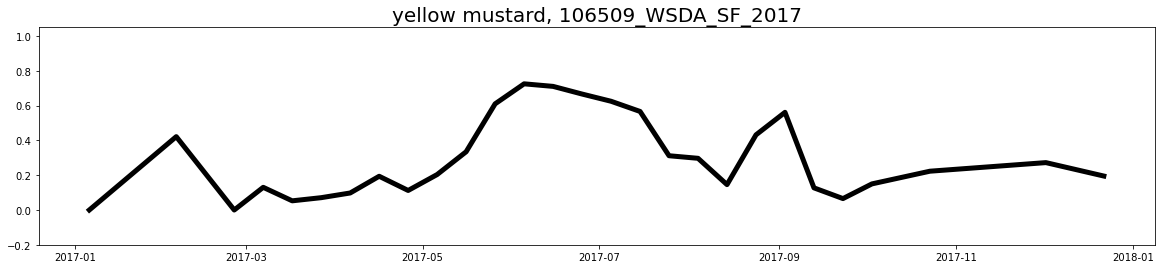

In [78]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

ID_1 = actual_double_predicted_single_IDs[2]
# plot EVI0
# plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
#          ground_truth[ground_truth.ID==ID_1].EVI.values,
#         c='k', linewidth=5);

plt.plot(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values,
         ground_truth[ground_truth.ID==ID_1].EVI.values,
         c='k', linewidth=5);


title = list(meta[meta.ID==ID_1].CropTyp)[0].replace(",", "")  + ", " + ID_1
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize=20);

In [84]:
meta[meta.ID.isin(actual_double_predicted_single_IDs)]["ExctAcr"].sum()

240.22581581805161

In [83]:
meta[meta.ID.isin(actual_single_predicted_double_IDs)]["ExctAcr"].sum()

482.9365592251606

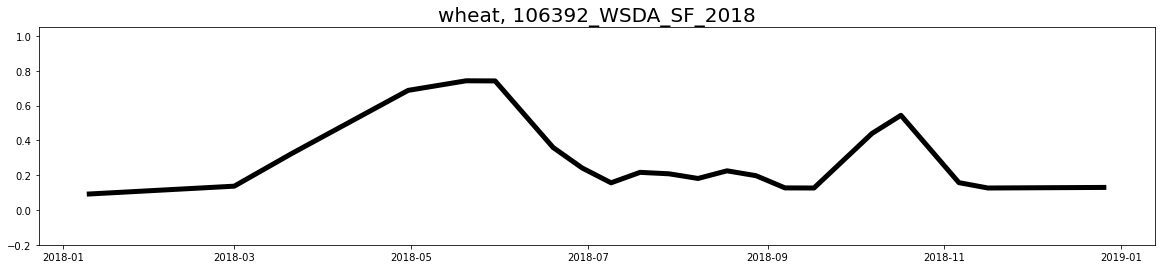

In [81]:
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

ID_1 = actual_single_predicted_double_IDs[0]
# plot EVIs
# plt.plot(range(len(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values)),
#          ground_truth[ground_truth.ID==ID_1].EVI.values,
#         c='k', linewidth=5);

plt.plot(ground_truth[ground_truth.ID==ID_1].human_system_start_time.values,
         ground_truth[ground_truth.ID==ID_1].EVI.values,
        c='k', linewidth=5);


title = list(meta[meta.ID==ID_1].CropTyp)[0].replace(",", "")  + ", " + ID_1
plt.ylim([-0.2, 1.05]);
plt.title(title , fontsize = 20);

## Fast WTD

In [ ]:

# import array
# s1 = array.array('d',[0, 0, 1, 2, 1, 0, 1, 0, 0])
# s2 = array.array('d',[0, 1, 2, 0, 0, 0, 0, 0, 0])
# d = dtw.distance_fast(s1, s2, use_pruning=True)

In [ ]:
# pip install -vvv --upgrade --force-reinstall dtaidistance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title,
                        X, y, axes=None, ylim=None,
                        cv=None, n_jobs=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, 
                    X=ground_truth_wide.loc[:, "EVI_1":], 
                    y=ground_truth_labels.Vote.values, 
                    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()